# Libraries and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error,  mean_absolute_error

To start with, I look at features. What they are, how many they are, whether there are blank values, what form they have, what type they are and what their volume is.
We notice that the feature "datetime" is of object form, so we convert it to datetime and replace it as index and sort it. This will help in analyzing and processing the data.

In [2]:
df = pd.read_csv('...\water_consumption\water.csv')

In [3]:
#Show the first 10 rows
df.head(10)

,Datetime,Consumption
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
5,2002-12-31 06:00:00,26222.0
6,2002-12-31 07:00:00,28702.0
7,2002-12-31 08:00:00,30698.0
8,2002-12-31 09:00:00,31800.0
9,2002-12-31 10:00:00,32359.0


In [4]:
#Show the last 10 rows
df.tail(10)

,Datetime,Consumption
131460,2016-01-01 15:00:00,29023.0
131461,2016-01-01 16:00:00,29300.0
131462,2016-01-01 17:00:00,30529.0
131463,2016-01-01 18:00:00,32845.0
131464,2016-01-01 19:00:00,32868.0
131465,2016-01-01 20:00:00,32530.0
131466,2016-01-01 21:00:00,32131.0
131467,2016-01-01 22:00:00,31318.0
131468,2016-01-01 23:00:00,29930.0
131469,2016-01-02 00:00:00,28315.0


In [5]:
#Show the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131470 entries, 0 to 131469
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Datetime     131470 non-null  object 
 1   Consumption  131470 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.0+ MB


In [6]:
#Show statistical info about the data
df.describe()

,Consumption
count,131470.000000
mean,32187.086476
std,6489.679293
min,14544.000000
25%,27664.000000
50%,31543.500000
75%,35761.750000
max,62009.000000


In [7]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Visualization and feature extracting

Then, for the first contact with the time series, a chart will be created for the total water consumption for the whole time of the dataframe. Through this we get an initial idea of patterns and seasonalities, furthermore we see the median and mean values at about 31.543 and 32.187 respectively. We notice that the time series maintains a pattern. By creating another chart but only for 2 years it is more clearly seen that the pattern is annual and catches a high peak in summer and a lower one in winter.
Furthermore It is interesting to see also weekly how it has a pattern as on Saturday and Sunday consumption drops while during the day it also shows it makes 2 peaks one short early and one longer and short late.

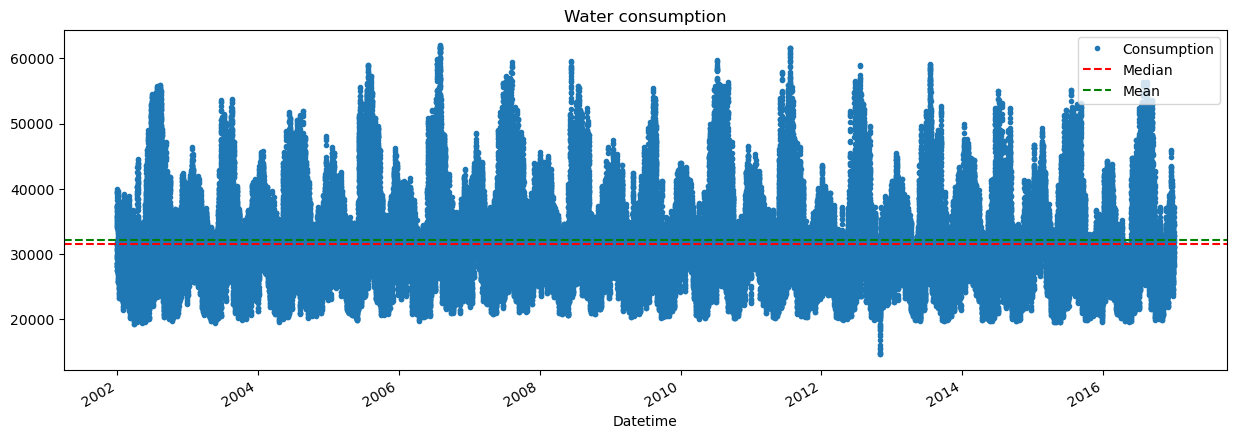

In [8]:
#Median and mean calculation
median_value = df['Consumption'].median()
mean_value = df['Consumption'].mean()

#Graph plot
df.plot(style='.',
        figsize=(15, 5),
        title='Water consumption')

plt.axhline(y=median_value, color='r', linestyle='--', label='Median')
plt.axhline(y=mean_value, color='g', linestyle='--', label='Mean')

plt.legend()
plt.show()

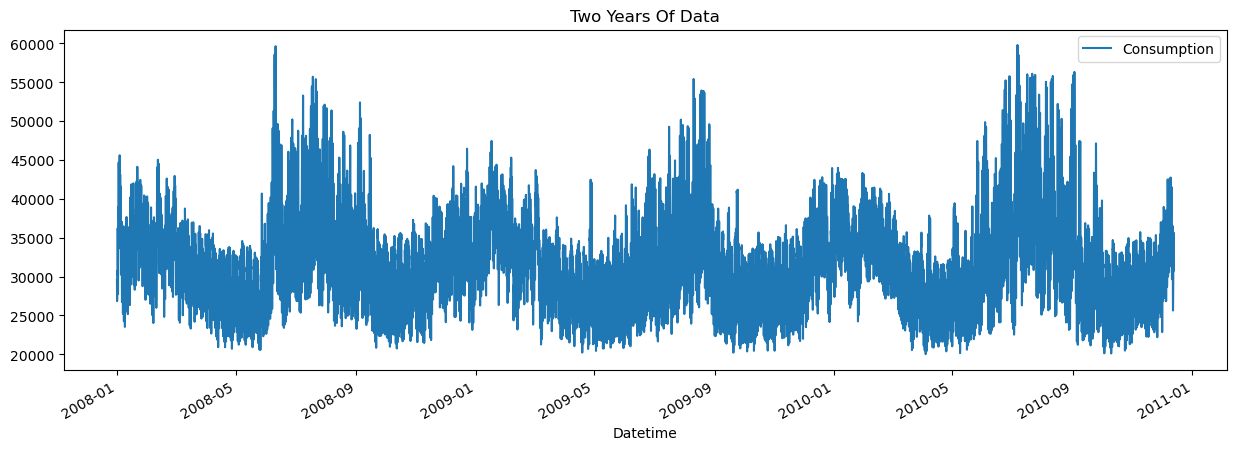

In [9]:
#Plot for 2 years
df.loc[(df.index > '01-01-2008') & (df.index < '12-13-2010')] \
    .plot(figsize=(15, 5), title='Two Years Of Data')
plt.show()


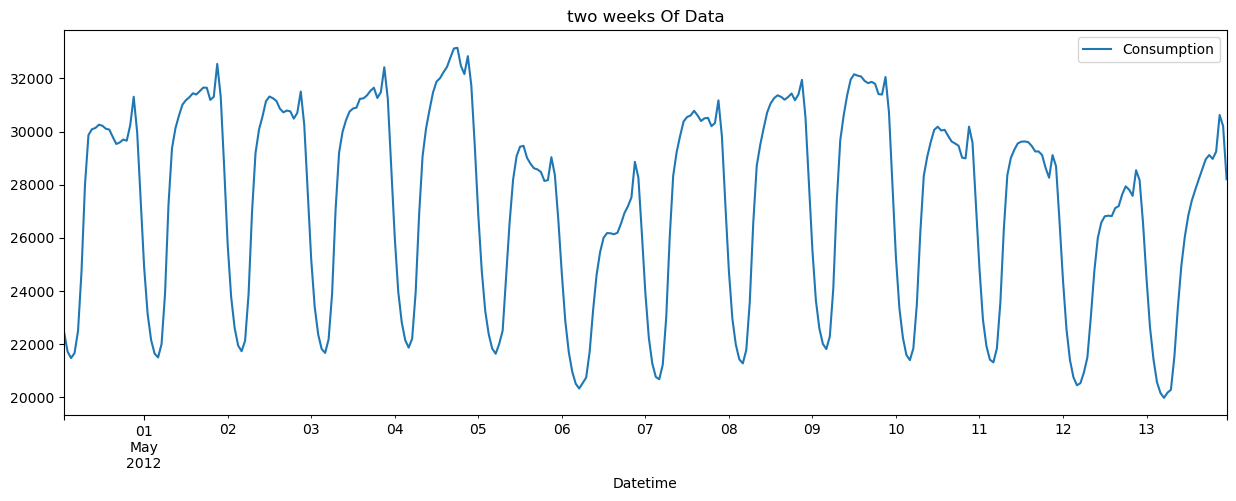

In [10]:
#Weekly pLot
df.loc[(df.index > '04-30-2012') & (df.index < '05-14-2012')] \
    .plot(figsize=(15, 5), title='two weeks Of Data')
plt.show()


To be able to extract more information we will create some features within the date. In addition, since there are patterns both at the low levels, such as the daily consumption, and at the high levels, such as the annual consumption, it will be important for the training of the model to be able to create these features so that they can be differentiated from each other and to create correlations between the patterns. For example, we see that Sundays have low consumption, so labeling using a feature as "day 7 of the week" creates a correlation between Sundays.

In [11]:
#Extract time features
df = df.copy()
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week

In [12]:
df

,Consumption,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1
...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,34478.0,19,5,4,12,2016,366,31,52
2016-12-31 20:00:00,33328.0,20,5,4,12,2016,366,31,52
2016-12-31 21:00:00,32197.0,21,5,4,12,2016,366,31,52


Now more targeted charts can be made for which boxplots will be chosen. Boxplots were chosen as they can give enough information about the data in one figure, including the variance, the distribution, the interquartile range, the media value and can also show any outliers.
For example in the following diagram for the boxplot of week one we can see that 50% of the values are within the pink range (between 29.000 and 36.000 approximately) with the median value falling close to 32.000, plus we see the lowest value around 21.000 and the highest around 46.000. Finally from the length of the lines above and below the box we see that there is a nearly normal distribution as the lines are about one and a half times longer than the box (the limit is 1.5 times longer, anything above this limit is an outlier as seen in the other boxplots).

In the following boxplots we can see more clearly and in greater detail what we have seen above. It can be seen that the demand for water increases during the summer months and that there is a great variation in consumption.
Two interesting things also have to do with the outliers, it seems that there are outliers upwards for the weeks around the hot summer months, without going into more detail I will make the assumption that the rise in temperature in recent years may play a role in this and perhaps the rise in temperature values may have been an important feature. Of course I mention again this is a hypothesis that I am clearly stating for my assessment in the assignment and will not delve too deeply in that direction for the sake of time and resources.
Furthermore it seems that the threshold values do not seem to have big differences compared to the maximum values which means that there is a consumption threshold which is close to 20,000 except for one time which is also shown in the general diagram above where it is an outlier which we can assume is an error either in the data or in the water supply network. This could be excluded from the training process but will not be done in this assignment. I refer to suggestions for improvement at the end of the assignment.

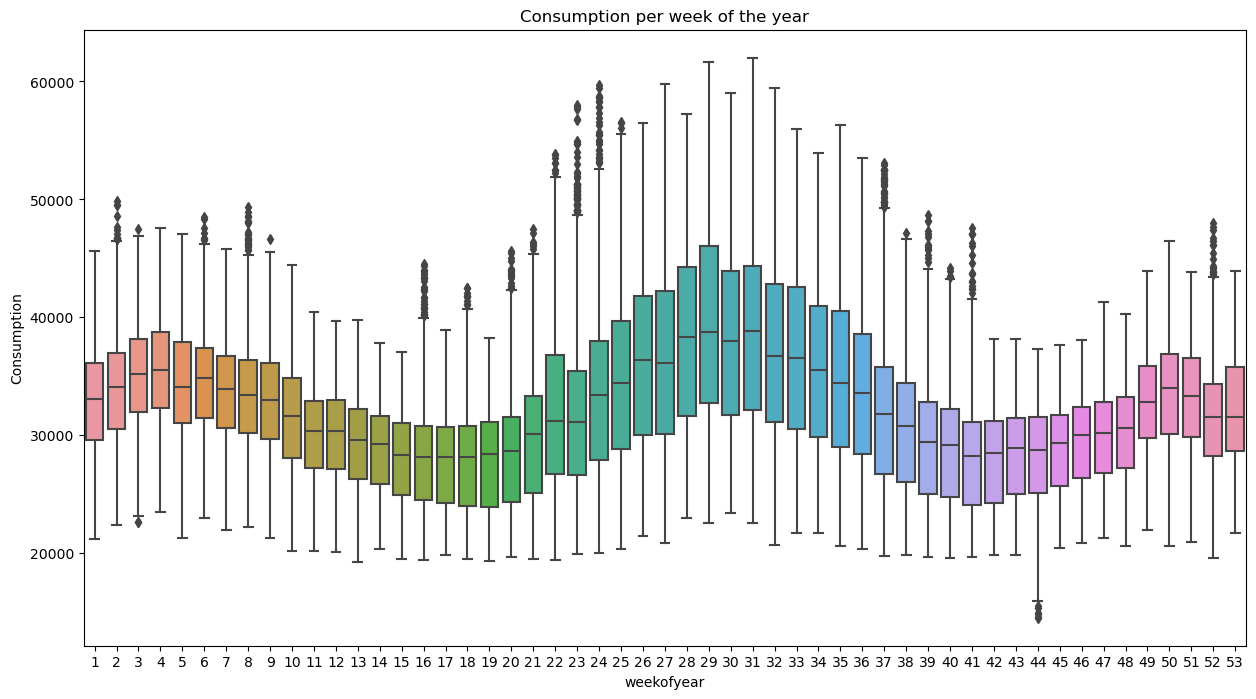

In [13]:
#Box plot for a year
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x='weekofyear', y='Consumption')
ax.set_title('Consumption per week of the year')
plt.show()

Below are the weekly and hourly graphs.
In the weekly ones we see that on weekdays the median hourly rate remains the same and the daily distributions are relatively close, while there is a change and less demand on weekends, one assumption being that large industries that consume many resources, such as water, are closed. It would be interesting if we could find a feature that reports how many industries or even buildings are being built in the area, as if they increase in volume it could have a direct influence on demand.
In the hourly data it seems that at night the demand drops while it is stable during working hours with a slight increase during the hours between 17:00 and 19:00. This may be due to the fact that people get off work and consume a lot of water together when they return home or if it is a rural area because they are watering. Again, these are all assumptions that I will not go into but can be used as improvements.

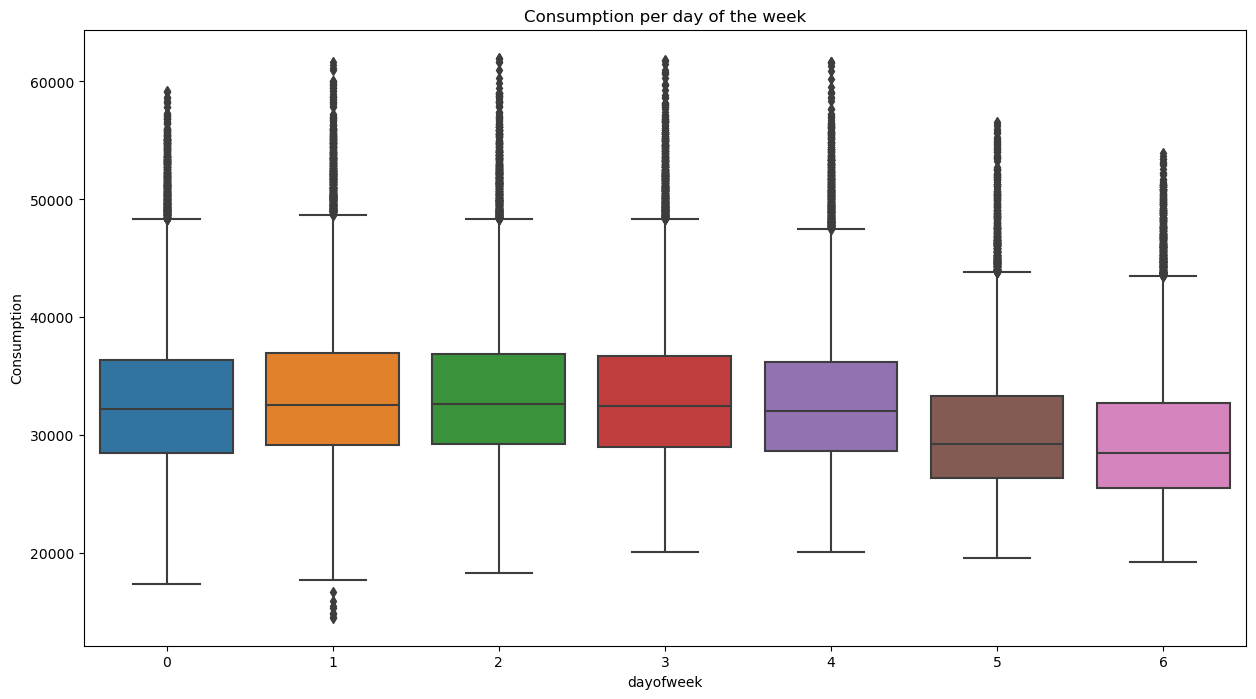

In [14]:
#Box plot for a week
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x='dayofweek', y='Consumption')
ax.set_title('Consumption per day of the week')
plt.show()

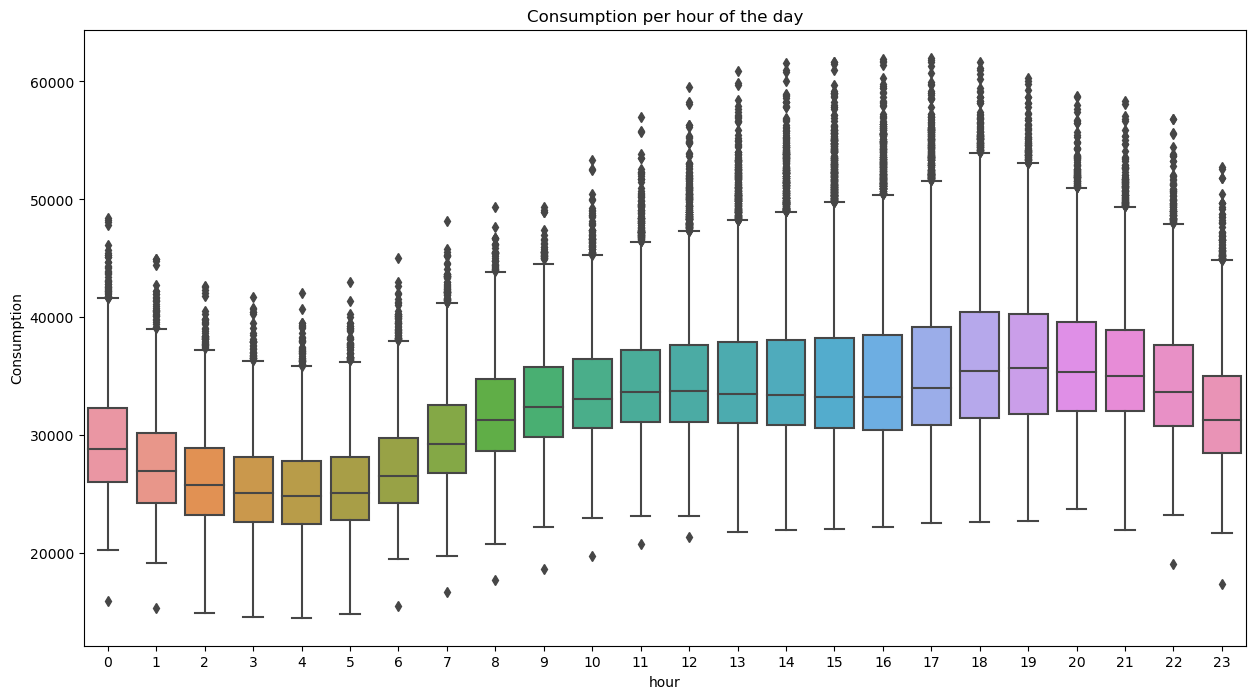

In [15]:
#Box plot for a day
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=df, x='hour', y='Consumption')
ax.set_title('Consumption per hour of the day')
plt.show()

As an additional feature we will use lags. Lags are values from a previous state of a feature. They help to find the longitudinal dependencies and patterns in the time series data. For example in the following case I create 3 lags which are annual points. It could be weekly, daily or every 4 years and there is no condition on how many there should be. The only point to watch out for is the forecast time horizon. Meaning, it is shown below that I have not used the one year ago point as lag1. I do this as the forecast will be for the next 2 years. If I had used lag1 the point 1 year ago then there would be a problem when forecasting the second year because the previous year would not exist, it would also be under forecast. So I take for lag 1 the point 2 years ago, for lag 2 the point 3 years ago and for lag 3 the point 4 years ago.
I find that three lags are sufficient for the assignment evaluation requirements.

In [16]:
#Lag feature extraction
target_map = df['Consumption'].to_dict()
df['lag1'] = (df.index - pd.Timedelta('728 days')).map(target_map)
df['lag2'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
df['lag3'] = (df.index - pd.Timedelta('1456 days')).map(target_map)

In [17]:
df

,Consumption,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,34478.0,19,5,4,12,2016,366,31,52,35781.0,40478.0,35899.0
2016-12-31 20:00:00,33328.0,20,5,4,12,2016,366,31,52,34893.0,40043.0,35600.0
2016-12-31 21:00:00,32197.0,21,5,4,12,2016,366,31,52,33847.0,39472.0,35136.0


# Model Training

Below we move on to data separation and model training. Cross validation was chosen for the validation of the model. 5 splits were used, with test size 24 * 365 * 2 as the forecast is 2 years ahead, in addition a gap between test data and validation data was chosen which is one day.
The timeseriesSplit fits the cross validation over time series data, i.e. the pattern it takes is as follows, in the first fold the test data is from the beginning to 2006 and the validation data from 2006 to 2008, the second fold the test data is from the beginning to 2008 and the validation data from 2008 to 2010 and continues like this until the fifth fold.
The reason for choosing cross validation is to prevent overfitting, and evaluate model performance in a more robust way than simple train-test.
For the sake of time and resources the selection of n_splits and gaps was done empirically and no in-depth research and repeated experiments were done to find the best performance.

In [18]:
#Define model and datasplit
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*2, gap=24)
df = df.sort_index()


In [19]:
preds = [] # List to store preds for each fold

mape_scores = [] # List to store mape_scores for each fold
mae_scores = [] # List to store mae_scores for each fold
rmse_scores = [] # List to store rmse_scores for each fold

train_rmse = []  # List to store training RMSE for each fold
val_rmse = []    # List to store validation RMSE for each fold

The algorithm chosen for this problem was XGBRegressor, which is an ensemble method that generates boosted decision trees and is a powerful and popular solution for interference problems. XGBoostRegressor is capable of capturing non-linear patterns in the data, is robust to a wide range of feature types, provides built-in regularization techniques and provides a wide range of hyperparameters that can be tuned to optimize model performance.

For the model parameter I choose decision trees (gbtrees) as the underlying boosting model, I set the estimators to 800 to capture complex patterns in the data, but i put an early stopping in case of overfitting which it work and stopped the model around the 500 estimators, i set rmse as loss function (the goal is to find the linear relationship between the input features and the target variable by minimizing the RMSE), i gave a depth of 5 to prevent overfitting and also lower the learning rate to 0.01 from the default 0.03 also to prevent overfitting. For the fit I gave the evaluation metric as "rmse" for both sets, lastly I set the set verbose to 50 because I think it is better for the visual purposes.

There will be a comment below to explain the lines directly.

In [20]:
fold = 1
for train_idx, val_idx in tss.split(df): #The loop for every fold, it sets the train and val df based an the split.
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]


    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year', #feature and target separation
                'lag1','lag2','lag3']
    TARGET = 'Consumption'

    X_train = train[FEATURES] #create the x and y train and val datasets, x will be the input and y the output
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    evals_result = {} #dict to store the evaluation resut for plotting afterwards
    print(f"===---===---===---===---Iteration {fold} begin---===---===---===---===")
    reg = xgb.XGBRegressor(booster='gbtree',    #The model
                           n_estimators=800,
                           objective='reg:squarederror',
                           max_depth=5,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,                  #Fit the model
            eval_metric="rmse",
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=40,
            verbose=50,)
    
    # Capture evaluation results manually
    evals_result = reg.evals_result()
    train_rmse_fold = evals_result["validation_0"]["rmse"]
    val_rmse_fold = evals_result["validation_1"]["rmse"]
    train_rmse.append(train_rmse_fold)
    val_rmse.append(val_rmse_fold)
    
    # Store preds
    y_pred = reg.predict(X_test)    
    preds.append(y_pred)
    # Calculate and store MAE
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)    
    # Calculate and store RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)    
    # Calculate and store MAPE
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mape_scores.append(mape)
    
    print(f"===---===---===---===---Iteration {fold} completed---===---===---===---===")
    fold +=1


===---===---===---===---Iteration 1 begin---===---===---===---===
[0]	validation_0-rmse:32566.79688	validation_1-rmse:33554.78125
[50]	validation_0-rmse:19927.75781	validation_1-rmse:20591.82617
[100]	validation_0-rmse:12376.90527	validation_1-rmse:12830.57715
[150]	validation_0-rmse:7909.28174	validation_1-rmse:8277.33398
[200]	validation_0-rmse:5359.11182	validation_1-rmse:5742.91650
[250]	validation_0-rmse:3981.17017	validation_1-rmse:4429.47559
[300]	validation_0-rmse:3296.59351	validation_1-rmse:3816.44238
[350]	validation_0-rmse:2944.52588	validation_1-rmse:3542.79370
[400]	validation_0-rmse:2756.25586	validation_1-rmse:3424.95923
[450]	validation_0-rmse:2646.59668	validation_1-rmse:3377.96704
[500]	validation_0-rmse:2576.45972	validation_1-rmse:3357.83325
[550]	validation_0-rmse:2527.64380	validation_1-rmse:3351.02734
[600]	validation_0-rmse:2480.76856	validation_1-rmse:3353.36523
[614]	validation_0-rmse:2472.56738	validation_1-rmse:3353.16064
===---===---===---===---Iteration 1

In [21]:
# Calculate mean scores across folds
mean_mape = np.mean(mape_scores)
mean_mae = np.mean(mae_scores)
mean_rmse = np.mean(rmse_scores)


In [22]:
# Report the evaluation metrics
print(f'Mean Absolute Percentage Error (MAPE): {mean_mape:.2f}%')
print(f'Mean Absolute Error (MAE): {mean_mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {mean_rmse:.2f}')

Mean Absolute Percentage Error (MAPE): 7.77%
Mean Absolute Error (MAE): 2580.41
Root Mean Squared Error (RMSE): 3503.91


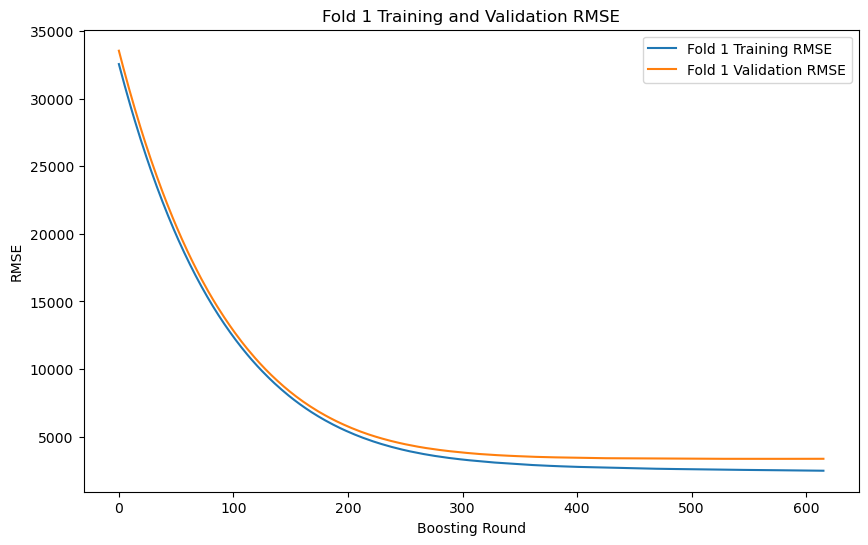

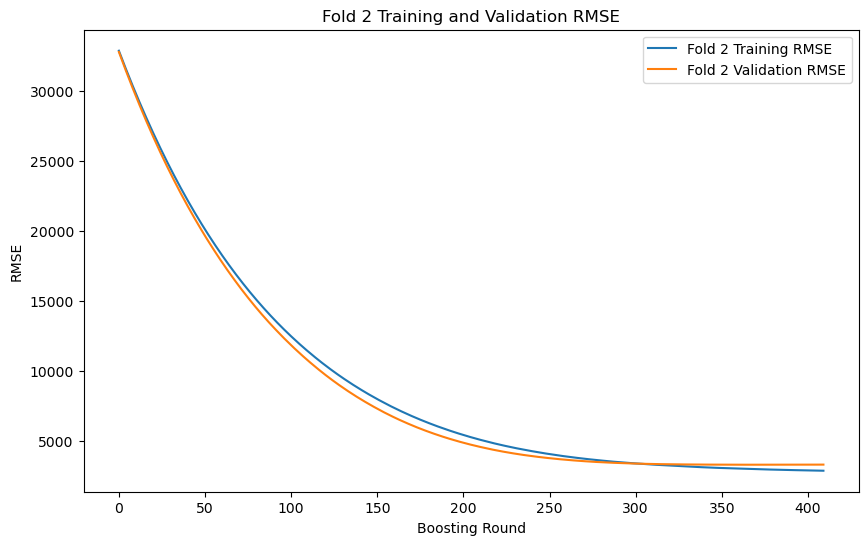

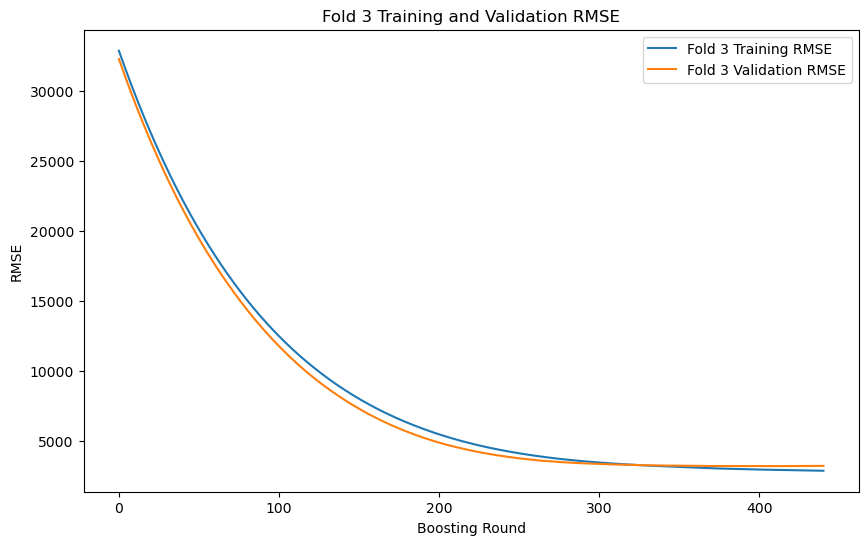

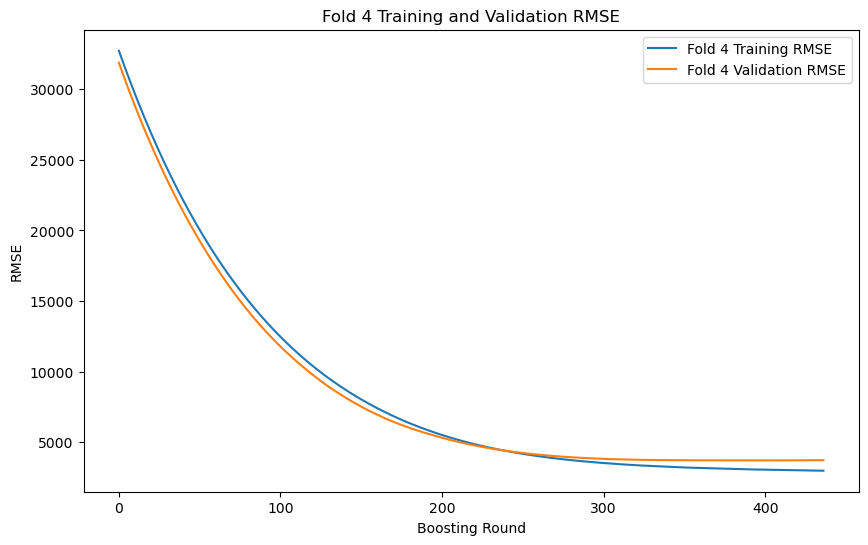

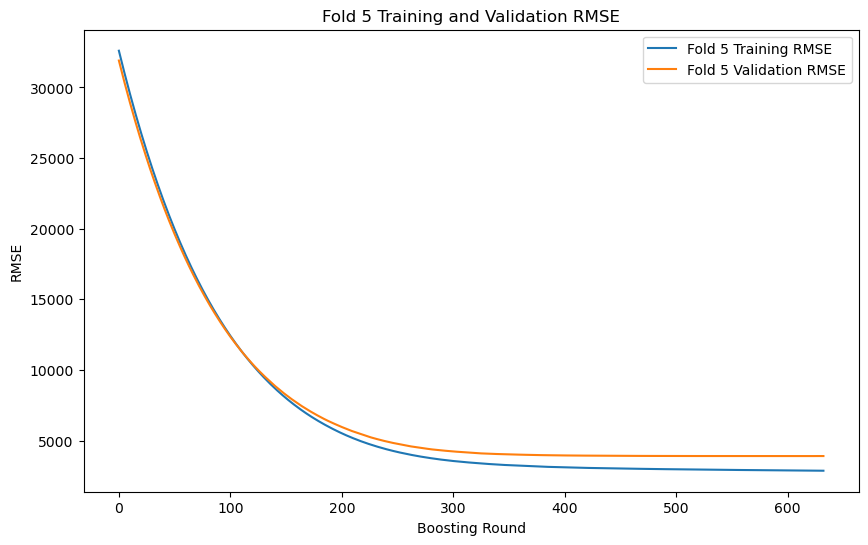

In [23]:
# Plot training and validation RMSE for each fold
for fold in range(len(train_rmse)):
    plt.figure(figsize=(10, 6))
    plt.plot(train_rmse[fold], label=f'Fold {fold + 1} Training RMSE')
    plt.plot(val_rmse[fold], label=f'Fold {fold + 1} Validation RMSE')
    plt.xlabel('Boosting Round')
    plt.ylabel('RMSE')
    plt.title(f'Fold {fold + 1} Training and Validation RMSE')
    plt.legend()
    plt.show()

I list above the measurements requested in the deliverable as well as the graph with train and validation. The graph shows that after 300 estimators the rmse starts to stabilize while at about 500 it starts to move away from the validation rmse, which means that at about 500 estimators the overfitting starts, but it does not increase sharply and is cut off by the early stop. 

# 2 Years Prediction

Below is the forecast for 2 years into the future. In order to do this, the model will need to be trained once more on the completed dataset. The difference here is that I changed the estimators to 350 as the graphs above show that this is the optimal point, so I don't expect the early stop to be triggered. The other parameters remain the same.

In [24]:
X = df[FEATURES]
y = df[TARGET]

reg = xgb.XGBRegressor(booster='gbtree',    #The model
                       n_estimators=350,
                       objective='reg:squarederror',
                       max_depth=5,
                       learning_rate=0.01)
reg.fit(X, y,         #Fit the model
        eval_set=[(X, y)],
        verbose=50)




[0]	validation_0-rmse:32510.83789
[50]	validation_0-rmse:19911.49414
[100]	validation_0-rmse:12403.48047
[150]	validation_0-rmse:8013.80713
[200]	validation_0-rmse:5556.87451
[250]	validation_0-rmse:4254.75781
[300]	validation_0-rmse:3631.89770
[349]	validation_0-rmse:3349.64990


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=350, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

After the final training on the whole dataset has been completed, the skeleton for the prediction has to be created. So we create the future index up to 2 years ahead. To do this we take the maximum and move forward one day.
The new df with index from 01-01-2017 to 31-12-2018 is created. In addition we can use a parameter that will help us in the search, it is called the future parameter and from there at the end we will be able to isolate only the values that have been predicted. This will be done as in the old dataset the future value will be false while in the new one it will be true. There are other ways but this one seems easier to me.

In [25]:
df.index.max()

Timestamp('2016-12-31 23:00:00')

In [26]:
# Create future dataframe
two_Years = pd.date_range('2017-01-01','2018-12-31', freq='1h')
two_Years_df = pd.DataFrame(index=two_Years)
two_Years_df['future'] = True
df['future'] = False
df_plus_twoYears = pd.concat([df, two_Years_df])

Then after the concat join of the 2 datasets (concat joins the 2 datasets one after the other) we create the rest of the features that do not exist in the two_Years_df which are the information about the days and the lags (here you can see that if we had taken lag 1 year back the lag1 for 2018 would be empty).

In [27]:
df_plus_twoYears['hour'] = df_plus_twoYears.index.hour
df_plus_twoYears['dayofweek'] = df_plus_twoYears.index.dayofweek
df_plus_twoYears['quarter'] = df_plus_twoYears.index.quarter
df_plus_twoYears['month'] = df_plus_twoYears.index.month
df_plus_twoYears['year'] = df_plus_twoYears.index.year
df_plus_twoYears['dayofyear'] = df_plus_twoYears.index.dayofyear
df_plus_twoYears['dayofmonth'] = df_plus_twoYears.index.day
df_plus_twoYears['weekofyear'] = df_plus_twoYears.index.isocalendar().week

In [28]:
target_map = df_plus_twoYears['Consumption'].to_dict()
df_plus_twoYears['lag1'] = (df_plus_twoYears.index - pd.Timedelta('728 days')).map(target_map)
df_plus_twoYears['lag2'] = (df_plus_twoYears.index - pd.Timedelta('1092 days')).map(target_map)
df_plus_twoYears['lag3'] = (df_plus_twoYears.index - pd.Timedelta('1456 days')).map(target_map)

Then from the future we added before as true we isolate the future df along with the features and load it into the model to make the predictions. Finally I will create some graphs for the conclusions.

In [29]:
complete_future = df_plus_twoYears.query('future').copy()

In [30]:
complete_future['pred'] = reg.predict(complete_future[FEATURES])

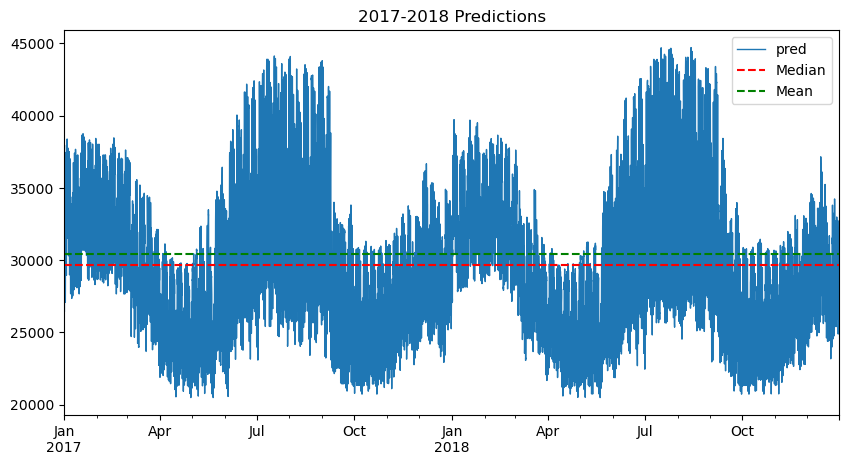

In [31]:
median_future_value = complete_future['pred'].median()
mean_future_value = complete_future['pred'].mean()

complete_future['pred'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='2017-2018 Predictions')

plt.axhline(y=median_future_value, color='r', linestyle='--', label='Median')
plt.axhline(y=mean_future_value, color='g', linestyle='--', label='Mean')

plt.legend()
plt.show()

In [32]:
complete_future['pred'].describe()

count    17497.000000
mean     30385.365234
std       5327.818359
min      20483.025391
25%      26513.812500
50%      29688.798828
75%      33798.511719
max      44703.515625
Name: pred, dtype: float64

In [33]:
start_date = '2002-01-01'
end_date = '2016-12-31' 

result = df['Consumption'].loc[start_date:end_date].resample('2Y').agg(['mean', 'median'])

print(result)

                    mean   median
Datetime                         
2002-12-31  31565.617106  31048.0
2004-12-31  31984.987856  31646.5
2006-12-31  32859.874172  32114.5
2008-12-31  33271.063113  32781.0
2010-12-31  32476.317499  31806.0
2012-12-31  31903.572862  31031.0
2014-12-31  31601.454047  30909.5
2016-12-31  31523.359496  30233.0


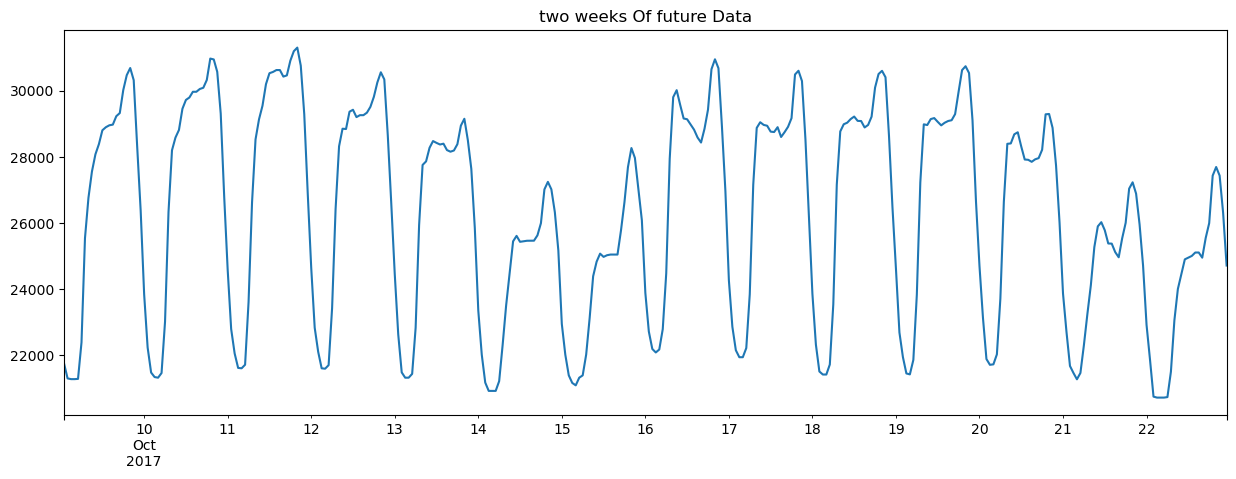

In [34]:
complete_future['pred'].loc[(complete_future.index > '10-09-2017') & (complete_future.index < '10-23-2017')] \
    .plot(figsize=(15, 5), title='two weeks Of future Data')
plt.show()

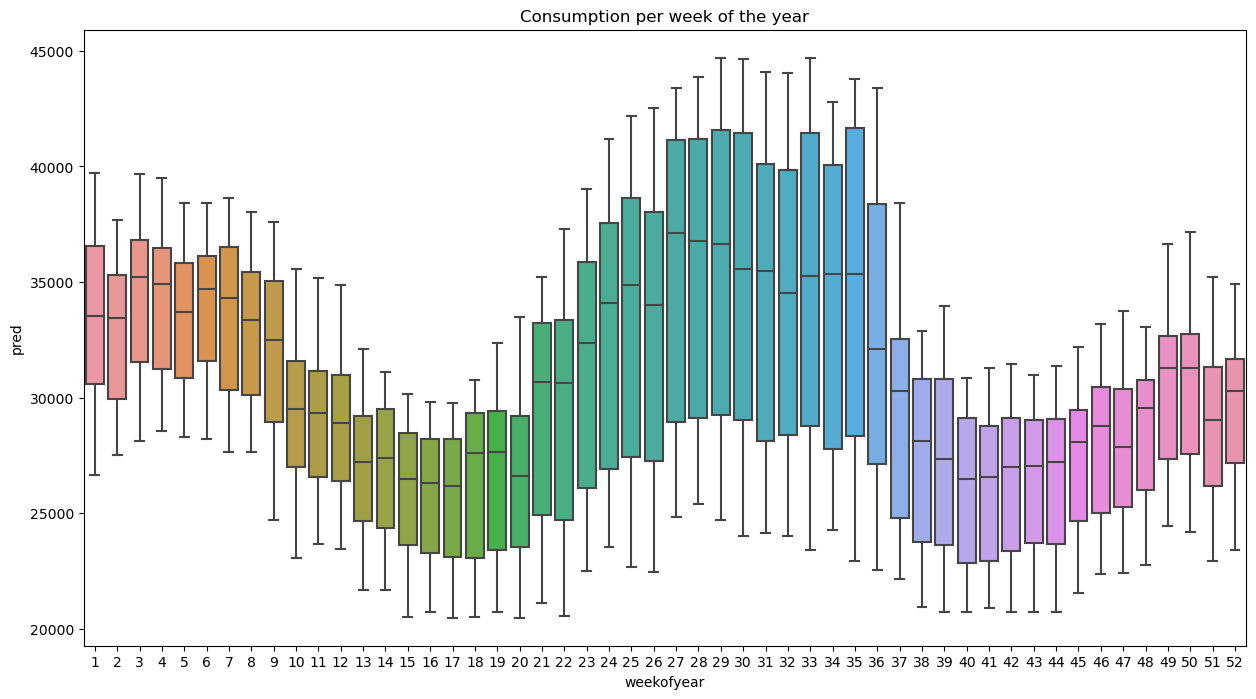

In [35]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(data=complete_future, x='weekofyear', y='pred')
ax.set_title('Consumption per week of the year')
plt.show()

In the conclusions the model did well in capturing and predicting patterns, as it seems to respond to both the weekly and annual very well. It shows a drop in median and mean values, this may be due to some extent to the fact that these values show a slight drop every two years. The major flaw is the outliers, outliers certainly play a role as it seems to have good accuracy in q2 and q3 while in q1 and q4 it seems to lag. Also most values seem to be clustered close to the mean values.

                                    ---===---===Suggestions for improvement===---===---
we could start with an outlier detection method to clean the dataset from any anomalies. Since we are talking about a continuous time series I would prefer not to throw away the value unless it is an outlier, but for example we could replace it with the average of the values of previous years, of course this is something that needs more study. But it would certainly improve performance.

Testing other models such as LSTM or Prophet would be good to use so that we can compare.

Finding and creating more features would also give useful insights and could help the model perform better.